**Type I Data - Without SVI**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
27


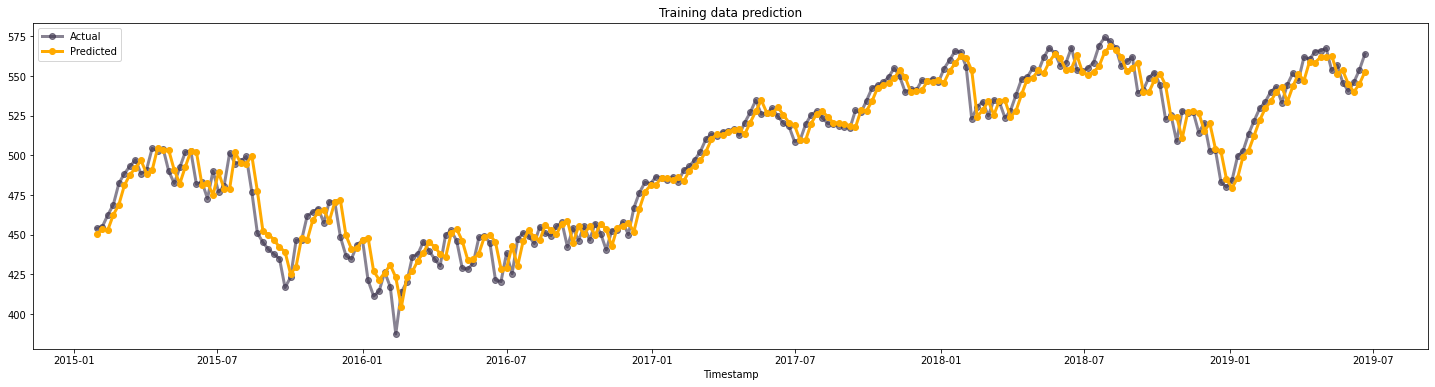

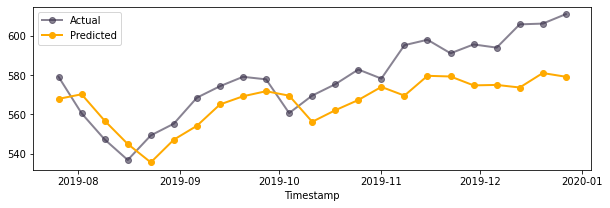

RMSE SVM: 16.663081780405562
MAE SVM: 14.813992545714887


In [8]:
# Importing Modules
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data
import matplotlib.pyplot as plt
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, utils, backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pmdarima as pm
import statsmodels.api as sm
from sklearn.svm import SVR

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Importing SVI Data & Renaming
aex = pd.read_csv(r"/content/drive/MyDrive/AEX_5years_new.csv")
aex = aex.rename(columns={'AEX: (Wereldwijd)': 'AEX SVI'})
amx = pd.read_csv(r"/content/drive/MyDrive/AMX_5years_new.csv")
amx = amx.rename(columns={'AMX Index: (Wereldwijd)': 'AMX SVI'})
dfaex = pd.DataFrame(aex)
dfamx = pd.DataFrame(amx)

# Renaming Columns 
dfaex = dfaex.rename(columns={'Week': 'Date'})
dfaex['Date'] = pd.to_datetime(dfaex['Date'])
dfaex = dfaex.set_index('Date')

dfamx = dfamx.rename(columns={'Week': 'Date'})
dfamx = dfamx.set_index('Date')

# Pulling Yahoo Finance Data
# Defining tickers & dates
ticker_aex = ['^AEX']
ticker_amx = ['^AMX']
start_date = '2015-01-01'
end_date = '2019-12-28'

# Downloading & transforming data to weekly data machting SVI
yfaex = yf.download(ticker_aex, start_date, end_date)
yfaex = yfaex.asfreq('W-FRI', method='pad') 
yfaex = pd.DataFrame(yfaex)

yfamx = yf.download(ticker_amx, start_date, end_date)
yfamx = yfamx.asfreq('W-FRI', method='pad') 
yfamx = pd.DataFrame(yfamx)

# Merging Datasets
df = pd.merge(dfaex, yfaex, left_index=True, right_index=True, how='outer')
dfamx = pd.merge(dfamx, yfamx, left_index=True, right_index=True, how='outer')
df

# Only Open Prices
columns = ['Open']
df = df[columns]

# Train Test
train_start_dt = '2015-01-01'
test_start_dt = '2019-06-28'
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Open']]
test = df.copy()[df.index >= test_start_dt][['Open']]

# Scaling Data
scaler = MinMaxScaler()
train['Open'] = scaler.fit_transform(train)
test['Open'] = scaler.transform(test)

# Converting to numpy arrays
train_data = train.values
test_data = test.values

# Defining Timesteps
timesteps=5
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

# Defining the model
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
model.fit(x_train, y_train[:,0])
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Reshape predictions & original data
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

# Rescale
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

# Prediction on Training Data
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = '#39304A', marker = 'o', linewidth=3.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = '#FFAA00', marker = 'o', linewidth=3.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

# Prediction on Test Data
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = '#39304A', marker = 'o', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = '#FFAA00', marker = 'o', linewidth=2.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

# Evaluation
from sklearn.metrics import mean_absolute_error as mae
rmse = np.sqrt(np.mean(((y_test_pred - y_test) ** 2)))
print(f'RMSE SVM: {rmse}')
error = mae(y_test, y_test_pred)
print(f'MAE SVM: {error}')

In [23]:
df['Actual_Price'] = df['Actual Price'].diff()
df['Actual_Price'] = df['Actual_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Create a new column that indicates whether the predicted value increased or decreased
df['Predicted_Price'] = df['Predicted Price'].diff()
df['Predicted_Price'] = df['Predicted_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Calculate the hit ratio
hit_ratio = (df['Actual_Price'] == df['Predicted_Price']).mean() 

print(f'Hit ratio: {hit_ratio:.2f}')

Hit ratio: 0.57


**Type II Data - With SVI**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


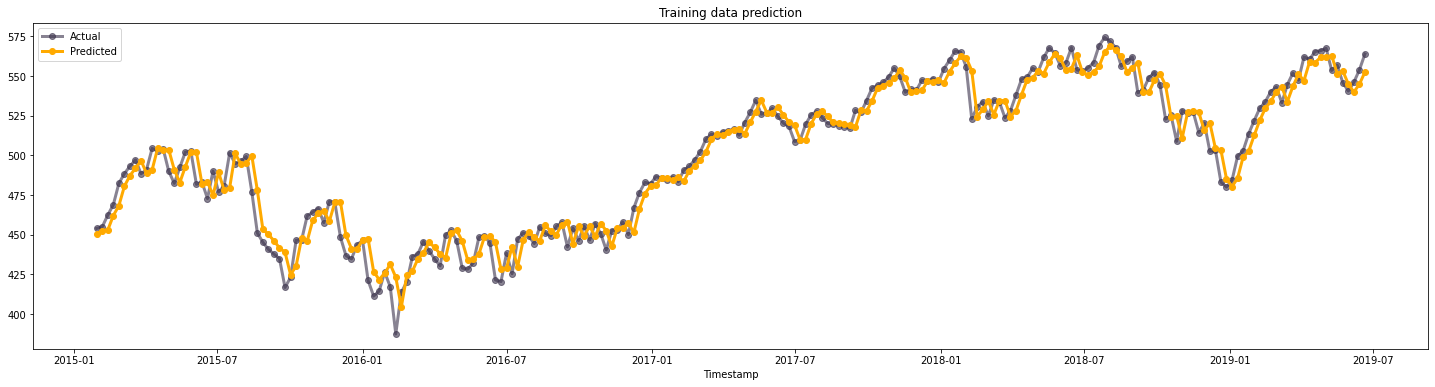

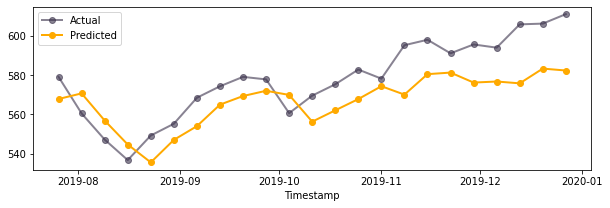

RMSE SVM: 15.764990671288922
MAE SVM: 14.177606475400916


In [24]:
# Importing SVI Data & Renaming
aex = pd.read_csv(r"/content/drive/MyDrive/AEX_5years_new.csv")
aex = aex.rename(columns={'AEX: (Wereldwijd)': 'AEX SVI'})
amx = pd.read_csv(r"/content/drive/MyDrive/AMX_5years_new.csv")
amx = amx.rename(columns={'AMX Index: (Wereldwijd)': 'AMX SVI'})
dfaex = pd.DataFrame(aex)
dfamx = pd.DataFrame(amx)

# Renaming Columns 
dfaex = dfaex.rename(columns={'Week': 'Date'})
dfaex['Date'] = pd.to_datetime(dfaex['Date'])
dfaex = dfaex.set_index('Date')

dfamx = dfamx.rename(columns={'Week': 'Date'})
dfamx = dfamx.set_index('Date')

# Pulling Yahoo Finance Data
# Defining tickers & dates
ticker_aex = ['^AEX']
ticker_amx = ['^AMX']
start_date = '2015-01-01'
end_date = '2019-12-28'

# Downloading & transforming data to weekly data machting SVI
yfaex = yf.download(ticker_aex, start_date, end_date)
yfaex = yfaex.asfreq('W-FRI', method='pad') 
yfaex = pd.DataFrame(yfaex)

yfamx = yf.download(ticker_amx, start_date, end_date)
yfamx = yfamx.asfreq('W-FRI', method='pad') 
yfamx = pd.DataFrame(yfamx)

# Merging Datasets
df = pd.merge(dfaex, yfaex, left_index=True, right_index=True, how='outer')
dfamx = pd.merge(dfamx, yfamx, left_index=True, right_index=True, how='outer')
df

# Open Prices and SVI
columns = ['Open', 'AEX SVI']
df = df[columns]

# Train Test
train_start_dt = '2015-01-01'
test_start_dt = '2019-06-28'
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Open', 'AEX SVI']]
test = df.copy()[df.index >= test_start_dt][['Open', 'AEX SVI']]

# Scaling Data
scaler = MinMaxScaler()
train['Open'] = scaler.fit_transform(train)
test['Open'] = scaler.transform(test)

scalerx = MinMaxScaler()
train['AEX SVI'] = scalerx.fit_transform(train)
test['AEX SVI'] = scalerx.transform(test)

# Converting to numpy arrays
train_data = train.values
test_data = test.values

# Defining Timesteps
timesteps=5
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

# Defining the model
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
model.fit(x_train, y_train[:,0])
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Reshape predictions & original data
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

# Rescale
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

# Prediction on Training Data
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = '#39304A', marker = 'o', linewidth=3.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = '#FFAA00', marker = 'o', linewidth=3.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

# Prediction on Test Data
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = '#39304A', marker = 'o', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = '#FFAA00', marker = 'o', linewidth=2.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

# Evaluation
from sklearn.metrics import mean_absolute_error as mae
rmse = np.sqrt(np.mean(((y_test_pred - y_test) ** 2)))
print(f'RMSE SVM: {rmse}')
error = mae(y_test, y_test_pred)
print(f'MAE SVM: {error}')

In [28]:
df['Actual_Price'] = df['Actual Price'].diff()
df['Actual_Price'] = df['Actual_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Create a new column that indicates whether the predicted value increased or decreased
df['Predicted_Price'] = df['Predicted Price'].diff()
df['Predicted_Price'] = df['Predicted_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Calculate the hit ratio
hit_ratio = (df['Actual_Price'] == df['Predicted_Price']).mean()

print(f'Hit ratio: {hit_ratio:.2f}')

Hit ratio: 0.67
